In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from surprise import SVD
from surprise import NMF
from surprise.model_selection import cross_validate
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import GridSearchCV
from surprise import KNNWithMeans
from surprise.model_selection import KFold
from surprise import accuracy
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords 
from nltk.tokenize import WordPunctTokenizer

In [2]:
df_restaurant_reviews = pd.read_pickle("df_restaurant_reviews.pkl")
df_restaurant_reviews.shape

(107128, 6)

In [3]:
df_restaurant_reviews.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'date', 'text'], dtype='object')

In [4]:
df_restaurant_reviews['year'] = df_restaurant_reviews['date'].map(lambda x: x.strftime('%Y'))

In [5]:
df_restaurant_reviews.drop(columns=['date'])
df_restaurant_reviews.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'date', 'text', 'year'], dtype='object')

In [6]:
year_count = df_restaurant_reviews[['review_id','year']].groupby('year').count().reset_index()

## Yearwise count of reviews

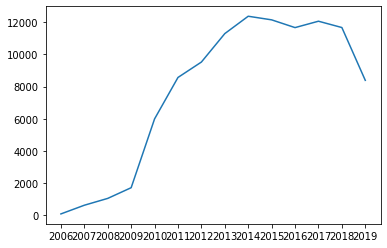

In [7]:
plt.plot(year_count['year'],year_count['review_id'])
plt.show()

## Count of reviews over time

In [8]:
temp=year_count.review_id.cumsum()

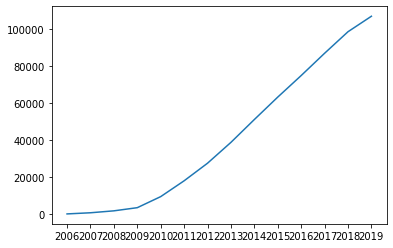

In [9]:
plt.plot(year_count['year'],temp)
plt.show()

In [10]:
df_restaurant_reviews=df_restaurant_reviews[['user_id', 'business_id', 'stars','year']]

In [11]:
df_restaurant_reviews.columns

Index(['user_id', 'business_id', 'stars', 'year'], dtype='object')

In [12]:
total_users=df_restaurant_reviews.user_id.nunique()
total_business=df_restaurant_reviews.business_id.nunique()

In [13]:
total_users

1561

In [14]:
total_business

6012

In [16]:
df_restaurant_reviews.dtypes

user_id        object
business_id    object
stars           int64
year           object
dtype: object

In [17]:
df_restaurant_reviews["year"] = df_restaurant_reviews["year"].astype(str).astype(int)
df_restaurant_reviews.dtypes

user_id        object
business_id    object
stars           int64
year            int32
dtype: object

In [18]:
df_restaurant_reviews.shape

(107128, 4)

In [19]:
temp=df_restaurant_reviews.copy(deep=True)

In [20]:
temp=temp[['user_id','business_id','stars']]

In [21]:
temp.columns

Index(['user_id', 'business_id', 'stars'], dtype='object')

In [22]:
df_restaurant_reviews.columns

Index(['user_id', 'business_id', 'stars', 'year'], dtype='object')

In [23]:
## Setting ratings training data after 2017 to zero for unbiased testing
tr=df_restaurant_reviews.copy(deep=True)
tr.loc[(tr.year>2017),'stars']= 0
tr.head(1)

,user_id,business_id,stars,year
32,H3wPBzQCKCKiHcV7GZK4kg,LkMtMHVetws5_7QfRjPtlg,2,2011


In [24]:
te=df_restaurant_reviews.copy(deep=True)

In [26]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(temp[["user_id", "business_id", "stars"]], reader)

## Collaborative Filtering using Memory Based KNN - Evaluation

In [27]:
reader = Reader(rating_scale=(1, 5))
tr = Dataset.load_from_df(tr[["user_id", "business_id", "stars"]], reader)
te = Dataset.load_from_df(te[["user_id", "business_id", "stars"]], reader)

In [28]:
similarity_user=[]
similarity_item=[]
rmse_user=[]
mse_user=[]
mae_user=[]
rmse_item=[]
mse_item=[]
mae_item=[]

In [29]:
user=[True,False]
name_name=["cosine","pearson","msd"]

for user_based in user:
    for name in name_name:
        sim_options = {
            "name": name,
            "min_support": 3,
            "user_based": user_based
        }
        
        algo = KNNWithMeans(sim_options=sim_options)
        trainset = tr.build_full_trainset()
        testset = te.build_full_trainset()
        testset=testset.build_testset()
        algo.fit(trainset)
        predictions = algo.test(testset)
        print("Accuracy for ",name,user_based)
        rmse=accuracy.rmse(predictions, verbose=True)
        mse=accuracy.mse(predictions, verbose=True)
        mae=accuracy.mae(predictions, verbose=True)
        if(user_based==True):
            similarity_user.append(name)
            rmse_user.append(rmse)
            mse_user.append(mse)
            mae_user.append(mae)
        else:
            similarity_item.append(name)
            rmse_item.append(rmse)
            mse_item.append(mse)
            mae_item.append(mae)

Computing the cosine similarity matrix...


C:\Users\Sanket Pandilwar\Anaconda3\lib\site-packages\surprise\prediction_algorithms\algo_base.py:248: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


Done computing similarity matrix.
Accuracy for  cosine True
RMSE: 1.4969
MSE: 2.2407
MAE:  1.1106
Computing the pearson similarity matrix...
Done computing similarity matrix.
Accuracy for  pearson True
RMSE: 1.4309
MSE: 2.0475
MAE:  0.9740
Computing the msd similarity matrix...
Done computing similarity matrix.
Accuracy for  msd True
RMSE: 1.4657
MSE: 2.1482
MAE:  1.0462
Computing the cosine similarity matrix...
Done computing similarity matrix.
Accuracy for  cosine False
RMSE: 1.4626
MSE: 2.1391
MAE:  1.0467
Computing the pearson similarity matrix...
Done computing similarity matrix.
Accuracy for  pearson False
RMSE: 1.4392
MSE: 2.0714
MAE:  0.9526
Computing the msd similarity matrix...
Done computing similarity matrix.
Accuracy for  msd False
RMSE: 1.4493
MSE: 2.1004
MAE:  0.9912


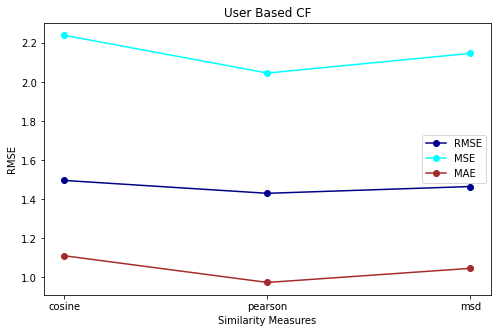

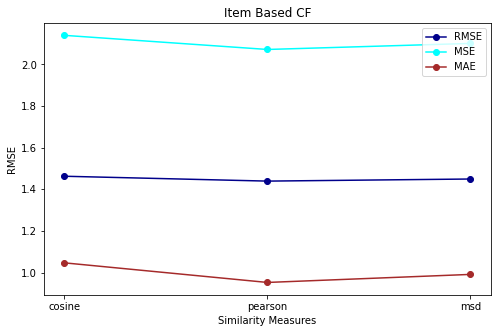

In [48]:
plt.xlabel("Similarity Measures")
plt.ylabel("RMSE")
plt.rcParams["figure.figsize"] = (8,5)

plt.plot(similarity_user,rmse_user,color="darkblue",marker='o')
plt.plot(similarity_user,mse_user,color="cyan",marker='o')
plt.plot(similarity_user,mae_user,color="brown",marker='o')
plt.title("User Based CF")
plt.legend(["RMSE","MSE","MAE"])
plt.show()

plt.xlabel("Similarity Measures")
plt.ylabel("RMSE")
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(similarity_item,rmse_item,color="darkblue",marker='o')
plt.plot(similarity_item,mse_item,color="cyan",marker='o')
plt.plot(similarity_item,mae_item,color="brown",marker='o')
plt.title("Item Based CF")
plt.legend(["RMSE","MSE","MAE"])
plt.show()

## Grid Search to find best set of params for Memory Based KNN

In [32]:
sim_options = {
    "name": ["msd", "cosine", "pearson"],
    "min_support": [3, 4, 5],
    "user_based": [False, True],
}

param_grid = {"sim_options": sim_options}

gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse", "mae"], cv=5)
gs.fit(data)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

## Grid Search to find best set of params for Model Based SVD

In [34]:
param_grid = {
    "n_epochs": [5, 10, 20],
    "lr_all": [0.002, 0.005],
    "reg_all": [0.2, 0.4, 0.6]
}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=5)

gs.fit(data)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

0.9729767140598804
{'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2}


## Item-Based Collaborative Filtering using ratings

In [35]:
business= pd.read_json("yelp_academic_dataset_business.json",encoding="utf8",lines=True)

In [36]:
business.columns

Index(['address', 'attributes', 'business_id', 'categories', 'city', 'hours',
       'is_open', 'latitude', 'longitude', 'name', 'postal_code',
       'review_count', 'stars', 'state'],
      dtype='object')

In [37]:
business=business[business.business_id.isin(df_restaurant_reviews.business_id)]

In [38]:
business.shape

(6012, 14)

In [39]:
business=business[['business_id','name']]

In [40]:
business.head()

,business_id,name
36,fnZrZlqW1Z8iWgTVDfv_MA,Carl's Jr
42,fhNf_sg-XzZ3e7HEVGuOZg,Meat Chix And Wieners
86,OWkS1FXNJbozn-qPg3LWxg,Mama Napoli Pizza
101,MTx-Zdl_KcU_z9G832XAjg,Taco Bell
130,Q_dh08clYUPj13GmCRzIVA,Kulinarya Express Filipino Kitchen


In [41]:
restaurant_features = df_restaurant_reviews.merge(business, on='business_id', how = 'inner')

In [42]:
restaurant_features = restaurant_features.pivot_table(index = 'name', columns = 'user_id', values = 'stars').fillna(0)

In [179]:
from scipy.sparse import csr_matrix
restaurant_features_matrix = csr_matrix(restaurant_features.values)

from sklearn.neighbors import NearestNeighbors
knn_recomm = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
knn_recomm.fit(restaurant_features_matrix)

Business='Loftti Cafe'
randomChoice=restaurant_features.index.tolist().index(Business)
distances, indices = knn_recomm.kneighbors(restaurant_features.iloc[randomChoice].values.reshape(1, -1), n_neighbors = 11)
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for Restaurant {0} on priority basis:\n'.format(restaurant_features.index[randomChoice]))
    else:
        print('{0}: {1}'.format(i, restaurant_features.index[indices.flatten()[i]]))

Recommendations for Restaurant Loftti Cafe on priority basis:

1: To See Roll
2: Brew Tea Bar
3: Cafe Summer
4: Zen Curry Express
5: Snow White Cafe
6: Is Sweet
7: Cafe 86
8: Dirt Dog - Las Vegas
9: Tea Space
10: Eis Cream Cafe


In [195]:
# Recommendations for Restaurant Chao Thai Restaurant on priority basis:

# 1: Rumbi Island Grill
# 2: Great Wall Chinese Restaurant
# 3: Basil Thai Fusion
# 4: Indian Bowl Cuisine
# 5: Chevron
# 6: Sandwich Carvery 108
# 7: San Gennaro Burger
# 8: The New Jugoo
# 9: Essence of Thai
# 10: The Grill
    
# Recommendations for Restaurant Delhi Indian Cuisine on priority basis:

# 1: Big Wong Restaurant
# 2: Art of Flavors
# 3: Mt Everest India's Cuisine
# 4: Mint Indian Bistro
# 5: El Cachi Mexican Kitchen
# 6: Japanese Cuisine By Omae
# 7: SLO-Boy
# 8: Indian Bowl Cuisine
# 9: Nem Nuong Bistro
# 10: Chao Thai Restaurant

## Item-based Collaborative filtering using reviews text TF-IDF score

In [94]:
yelp_data = new[['business_id', 'user_id', 'stars', 'text']]

In [95]:
import string
from nltk.corpus import stopwords
stop = []
for word in stopwords.words('english'):
    s = [char for char in word if char not in string.punctuation]
    stop.append(''.join(s))

In [97]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return " ".join([word for word in nopunc.split() if word.lower() not in stop])

In [98]:
yelp_data['text'] = yelp_data['text'].apply(text_process)

C:\Users\Sanket Pandilwar\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [107]:
userid_df = yelp_data[['user_id','text']]
business_df = yelp_data[['business_id', 'text']]

In [108]:
userid_df = userid_df.groupby('user_id').agg({'text': ' '.join})
business_df = business_df.groupby('business_id').agg({'text': ' '.join})

In [114]:
userid_vectorizer = TfidfVectorizer(tokenizer = WordPunctTokenizer().tokenize, max_features=5000)
userid_vectors = userid_vectorizer.fit_transform(userid_df['text'])
userid_vectors.shape

(1561, 5000)

In [116]:
#Business id vectorizer
businessid_vectorizer = TfidfVectorizer(tokenizer = WordPunctTokenizer().tokenize, max_features=5000)
businessid_vectors = businessid_vectorizer.fit_transform(business_df['text'])
businessid_vectors.shape

(6012, 5000)

In [185]:
P = pd.DataFrame(userid_vectors.toarray(), index=userid_df.index, columns=userid_vectorizer.get_feature_names())
Q = pd.DataFrame(businessid_vectors.toarray(), index=business_df.index, columns=businessid_vectorizer.get_feature_names())

In [186]:
xyz=P.dot(Q.T)

In [187]:
K=xyz.T

In [188]:
K.head()

user_id,-267Yx8RmdP6io2-qI4UcQ,-50XWnmQGqBgEI-9ANvLlg,-8rSnT5ztVk6vmTDkxTqsQ,-9S_Fh-sQebyB1yhEM5zHw,-9WVpTW5LAEo9y6PbW0-cw,-ARdx8hOcEWlMDjzwLYZ_g,-C-l8EHSLXtZZVfUAUhsPA,-EJorVxe7h2GSxdiRyMmDA,-Fy91nyOFqPv9M_MaZ4W2g,-INftgcdy5pCuFuKBBZOmg,...,zXBH5QYe1WJCvQdkYBs9JQ,z_tqPytGQF_tDw_buHKJcw,zbahX7xiLbjWWM4_L43lhg,zgV0ZroIF956gw4cul8MHA,zpwWpno3U-oZaG3AJuKqSQ,zsJLk34mTDMyuVS_EaBLxw,zwhty_ZmxbHAHoDfMjNbag,zwpP3Lt8USKS91Ds52G8UA,zx3y74_pvIRuQSVIrgzCew,zzPvEodjvLPe-5NvV0U_cg
business_id,,,,,,,,,,,,,,,,,,,,,
--9e1ONYQuAa-CB_Rrw7Tw,0.565643,0.550337,0.210672,0.204591,0.309399,0.139842,0.549991,0.467994,0.518577,0.367320,...,0.206837,0.285518,0.463911,0.448999,0.490713,0.553743,0.524931,0.236899,0.145549,0.492703
-0RkJ_uIduNLWQrphbADRw,0.439781,0.430723,0.186420,0.110904,0.243027,0.128834,0.413397,0.356621,0.451406,0.289219,...,0.174839,0.242829,0.349582,0.393340,0.374620,0.427854,0.425695,0.221881,0.116419,0.379519
-1m9o3vGRA8IBPNvNqKLmA,0.466994,0.456438,0.174972,0.175881,0.287233,0.139491,0.476687,0.376524,0.433594,0.296706,...,0.171301,0.247609,0.389300,0.389388,0.409674,0.455255,0.437235,0.206325,0.144996,0.397455
-1vfRrlnNnNJ5boOVghMPA,0.312360,0.312763,0.119292,0.043154,0.151908,0.061280,0.359668,0.240773,0.298940,0.216795,...,0.102573,0.145998,0.238392,0.304181,0.252447,0.326553,0.275728,0.129639,0.071837,0.321535
-2nfJ8yK54A7Md2RzmMR4g,0.193512,0.183743,0.045609,0.055048,0.099276,0.044443,0.202865,0.175911,0.209966,0.105847,...,0.069470,0.123049,0.156442,0.179207,0.146516,0.203418,0.195527,0.092207,0.041003,0.186744


In [189]:
from scipy.sparse import csr_matrix
restaurant_features_matrix = csr_matrix(K.values)

from sklearn.neighbors import NearestNeighbors
knn_recomm = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
knn_recomm.fit(restaurant_features_matrix)

Business='oUX2bYbqjqST-urKbOHG6w'

randomChoice=K.index.tolist().index(Business)
distances, indices = knn_recomm.kneighbors(K.iloc[randomChoice].values.reshape(1, -1), n_neighbors = 11)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for Restaurant {0} on priority basis:\n'.format(K.index[randomChoice]))
    else:
#         print(indices.flatten()[i])
#         print()
        print(business[business.business_id==K.index[indices.flatten()[i]]].name)
#         print('{0}: {1}'.format(i, K.index[indices.flatten()[i]]))

Recommendations for Restaurant oUX2bYbqjqST-urKbOHG6w on priority basis:

206914    Icy Juicy
Name: name, dtype: object
160870    La Luna Tea and Dessert Bar
Name: name, dtype: object
81576    LaPostté
Name: name, dtype: object
22424    Cafe Summer
Name: name, dtype: object
119792    Tea Space
Name: name, dtype: object
158935    Tea Station
Name: name, dtype: object
33245    Fresh Cup
Name: name, dtype: object
129960    Ice Monster Cafe
Name: name, dtype: object
133758    Snow White Cafe
Name: name, dtype: object
12657    Brew Tea Bar
Name: name, dtype: object


In [177]:
business[business.name=='Loftti Cafe']

,business_id,name
308,oUX2bYbqjqST-urKbOHG6w,Loftti Cafe


In [ ]:
# Recommendations for Restaurant Delhi Indian Cuisine on priority basis:
# CF recommendation Using Rating
# 1: Big Wong Restaurant
# 2: Art of Flavors
# 3: Mt Everest India's Cuisine
# 4: Mint Indian Bistro
# 5: El Cachi Mexican Kitchen
# 6: Japanese Cuisine By Omae
# 7: SLO-Boy
# 8: Indian Bowl Cuisine
# 9: Nem Nuong Bistro
# 10: Chao Thai Restaurant
    
# Recommendations for Restaurant 3LWsVfsSmb_Nzbi2YQ-NIA(Delhi Indian Cuisine) on priority basis:
# CF recommendation Using Reviews text
# 89106    Namaste Indian Cuisine
# Name: name, dtype: object
# 66700    Mt Everest India's Cuisine
# Name: name, dtype: object
# 11930    Angara India Spice Grill
# Name: name, dtype: object
# 139707    Mint Indian Bistro
# Name: name, dtype: object
# 62112    Tamba
# Name: name, dtype: object
# 51892    Taj Palace
# Name: name, dtype: object
# 48834    Paradise India
# Name: name, dtype: object
# 192754    India Oven Masala Bar & Grill
# Name: name, dtype: object
# 64370    Mint Indian Bistro
# Name: name, dtype: object
# 120985    India Palace
# Name: name, dtype: object
        
        
    
# Recommendations for Restaurant Chao Thai Restaurant on priority basis:
# CF recommendation Using Rating
# 1: Rumbi Island Grill
# 2: Great Wall Chinese Restaurant
# 3: Basil Thai Fusion
# 4: Indian Bowl Cuisine
# 5: Chevron
# 6: Sandwich Carvery 108
# 7: San Gennaro Burger
# 8: The New Jugoo
# 9: Essence of Thai
# 10: The Grill
    
# Recommendations for Restaurant QmVF3KJ07PsdroCFwOC_Ow(Chao Thai Restaurant) on priority basis:
# CF recommendation Using Reviews text
# 116024    Lucki Thai
# Name: name, dtype: object
# 142155    Pin Kaow Thai Restaurant
# Name: name, dtype: object
# 58844    Pin Kaow Thai
# Name: name, dtype: object
# 197265    Table Thai Bar & Bistro
# Name: name, dtype: object
# 80719    Thai Style Noodle House
# Name: name, dtype: object
# 56726    Thai House
# Name: name, dtype: object
# 173863    Prommares Thai Food
# Name: name, dtype: object
# 203882    Surang's Thai Kitchen
# Name: name, dtype: object
# 162323    Thai Room
# Name: name, dtype: object
# 14336    Panna Thai Restaurant
# Name: name, dtype: object